# 0. Imports and Load Data

In [3]:
import os
import glob
import random
import json
from pathlib import Path
import pandas as pd
import yaml
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from ultralytics import YOLO
import warnings

warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\NIL\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
DATA_YAML_PATH = "../data/data.yaml"

assert os.path.exists(DATA_YAML_PATH), f"data.yaml not found in {DATA_YAML_PATH}"

with open(DATA_YAML_PATH, "r") as f:
    data_cfg = yaml.safe_load(f)

data_cfg

{'train': '../data/train/images',
 'val': '../data/valid/images',
 'test': '../data/test/images',
 'nc': 17,
 'names': ['car',
  'cardboard box',
  'forklift',
  'freight container',
  'gloves',
  'helmet',
  'ladder',
  'license plate',
  'person',
  'qr code',
  'road sign',
  'safety vest',
  'traffic cone',
  'traffic light',
  'truck',
  'van',
  'wood pallet'],
 'roboflow': {'workspace': 'srafil-ar',
  'project': 'forklift-6ms6v',
  'version': 1,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/srafil-ar/forklift-6ms6v/dataset/1'}}

In [5]:
train_dir = data_cfg.get("train")
val_dir   = data_cfg.get("val")
test_dir  = data_cfg.get("test", None)
class_names = data_cfg.get("names", [])
nc = int(data_cfg.get("nc", len(class_names)))

print("Train images dir:", train_dir)
print("Val images dir  :", val_dir)
print("Test images dir :", test_dir)
print("Classes (nc)     :", nc)
print("Classes name:", class_names)

Train images dir: ../data/train/images
Val images dir  : ../data/valid/images
Test images dir : ../data/test/images
Classes (nc)     : 17
Classes name: ['car', 'cardboard box', 'forklift', 'freight container', 'gloves', 'helmet', 'ladder', 'license plate', 'person', 'qr code', 'road sign', 'safety vest', 'traffic cone', 'traffic light', 'truck', 'van', 'wood pallet']


# 1. Data Analysis: First Sight

In [ ]:
# def yolo_label_paths(img_dir: str) -> list:
#     img_paths = []
#     for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
#         img_paths.extend(glob.glob(os.path.join(img_dir, ext)))
#     label_paths = []
#     for ip in img_paths:
#         lp = ip.replace(os.sep + "images" + os.sep, os.sep + "labels" + os.sep)
#         lp = os.path.splitext(lp)[0] + ".txt"
#         label_paths.append((ip, lp))
#     return label_paths

# Rewritten using pathlib to avoid Windows path issues with glob + string replace.
# The previous version failed to map images → labels reliably, producing empty EDA.
def yolo_label_paths(img_dir: str) -> list:
    img_dir = Path(img_dir)
    label_dir = img_dir.parent / "labels"
    pairs = []
    for img_path in img_dir.rglob("*"):
        if img_path.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp"]:
            label_path = label_dir / (img_path.stem + ".txt")
            pairs.append((str(img_path), str(label_path)))

    return pairs


def read_yolo_labels(label_path: str):
    if not os.path.exists(label_path):
        return []
    rows = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cls_id = int(float(parts[0]))
                cx, cy, w, h = map(float, parts[1:5])
                rows.append((cls_id, cx, cy, w, h))
    return rows


In [ ]:
def analyze_split(img_dir: str, class_names: list):
    pairs = yolo_label_paths(img_dir)
    per_class = Counter()
    objs_per_image = []
    areas = []

    for _, lbl_path in pairs:
        labels = read_yolo_labels(lbl_path)
        objs_per_image.append(len(labels))
        for (cls_id, cx, cy, w, h) in labels:
            per_class[cls_id] += 1
            areas.append(w * h)

    df_classes = pd.DataFrame({
        "class_id": list(per_class.keys()),
        "count": list(per_class.values())
    })
    df_classes["class_name"] = df_classes["class_id"].apply(lambda i: class_names[i] if i < len(class_names) else str(i))

    df_objs = pd.DataFrame({"objects_per_image": objs_per_image})
    df_areas = pd.DataFrame({"bbox_area_norm": areas})

    return df_classes.sort_values("count", ascending=False), df_objs, df_areas

df_classes_train, df_objs_train, df_areas_train = analyze_split(train_dir, class_names)
df_classes_train.head(), df_objs_train.describe(), df_areas_train.describe()

(    class_id  count         class_name
 3          2  24213           forklift
 2          8  20480             person
 0          1   1266      cardboard box
 13        12   1023       traffic cone
 1          3    447  freight container,
        objects_per_image
 count       20546.000000
 mean            2.405237
 std             2.472610
 min             1.000000
 25%             1.000000
 50%             2.000000
 75%             3.000000
 max            47.000000,
        bbox_area_norm
 count    49418.000000
 mean         0.155603
 std          0.224430
 min          0.000010
 25%          0.010547
 50%          0.045352
 75%          0.203203
 max          1.000000)

### How is the date distribuited?

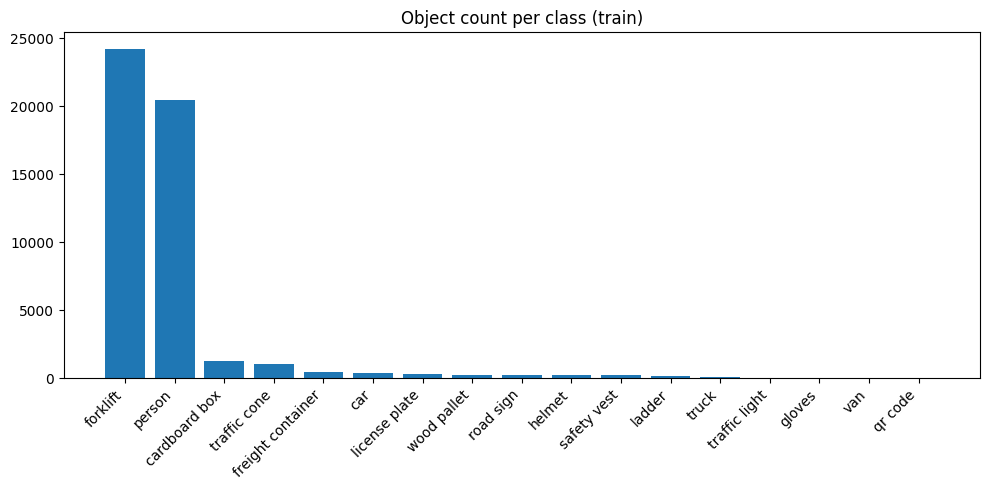

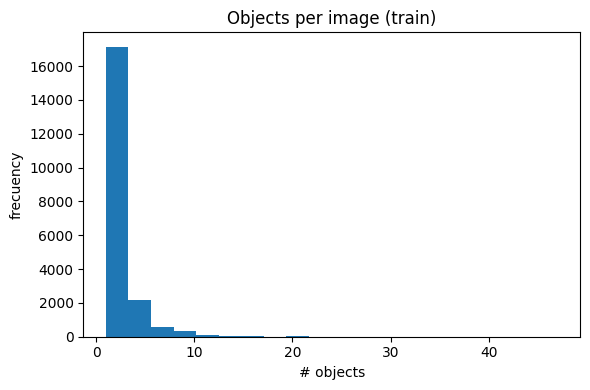

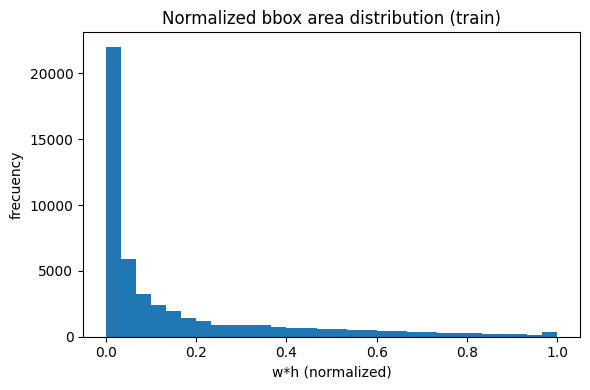

In [23]:
plt.figure(figsize=(10,5))
plt.bar(df_classes_train["class_name"], df_classes_train["count"])
plt.xticks(rotation=45, ha='right')
plt.title("Object count per class (train)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_objs_train["objects_per_image"], bins=20)
plt.title("Objects per image (train)")
plt.xlabel("# objects")
plt.ylabel("frecuency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_areas_train["bbox_area_norm"], bins=30)
plt.title("Normalized bbox area distribution (train)")
plt.xlabel("w*h (normalized)")
plt.ylabel("frecuency")
plt.tight_layout()
plt.show()

#### Analysis:

[Image 1]
1. Severe class imbalance. Forklift (~25k) and Person (~20k) dominate the dataset. Most other classes have <1k instances, and some (<200) are borderline rare.
2. Impact on model. YOLO model will Learn forklifts and persons very quickly but undertrain small or rare objects. 
3. It is possible produce lower mAP50-95 for classes with low frequency and small area.


[Image 2]
1. Most images are low-density scenes. The distribution is extremely right-skewed. Most images contains <4 images.
2. Training implications. YOLO will learn faster on low-density images, but crowded scenes will remain challenging. 
3. mAP may be stable overall but usually lower on images with many objects, since those scenes are harder to detect accurately and the dataset contains relatively few of them.

[Image 3]
1. Most objects have very small bounding-box areas, indicating that the dataset contains many small objets/targets that are harder to detect consistently.
2. Even though the dataset contains many examples of small objects, their reduced size still makes them harder to localize precisely, so mAP for small-scale objects may be lower than for larger ones.

#### Analyze ratio wxh

In [29]:
def analyze_ratios(img_dir: str):
    ratios = []

    for _, lbl_path in yolo_label_paths(img_dir):
        labels = read_yolo_labels(lbl_path)
        for (_, cx, cy, w, h) in labels:
            if h > 0:
                ratios.append(w / h)

    return pd.DataFrame({"aspect_ratio": ratios})

In [30]:
df_ratios_train = analyze_ratios(train_dir)
df_ratios_train.describe()

,aspect_ratio
count,49418.000000
mean,0.974316
std,0.727486
min,0.065385
25%,0.520000
50%,0.975889
75%,1.009174
max,12.233333


1. Mean 0.97 is almost 1. This means most boxes are almost square.
2. About 25% of objects are tall, with ratios below 0.52, which adds geometric variety for the model.
3. About 75% stay near 1.0, showing that wide objects exist but are not dominant.

### Object Scale Categories

In [41]:
df_areas_train.describe()

,bbox_area_norm
count,49418.000000
mean,0.155603
std,0.224430
min,0.000010
25%,0.010547
50%,0.045352
75%,0.203203
max,1.000000


The bbox area distribution is heavily skewed towards small values: 75% of objects occupy less than ~20% of the image area, and half of them less than ~5%

#### co-ocurrence

In [42]:
import numpy as np

num_classes = len(class_names)
cooc = np.zeros((num_classes, num_classes), dtype=int)

for _, lbl_path in yolo_label_paths(train_dir):
    labels = read_yolo_labels(lbl_path)
    cls_ids = list({lbl[0] for lbl in labels})  # unique classes in image
    
    for i in range(len(cls_ids)):
        for j in range(i+1, len(cls_ids)):
            a, b = cls_ids[i], cls_ids[j]
            cooc[a, b] += 1
            cooc[b, a] += 1  # symmetric

cooc_df = pd.DataFrame(cooc, index=class_names, columns=class_names)
cooc_df

,car,cardboard box,forklift,freight container,gloves,helmet,ladder,license plate,person,qr code,road sign,safety vest,traffic cone,traffic light,truck,van,wood pallet
car,0,3,135,12,0,9,3,30,66,3,12,3,9,3,60,3,9
cardboard box,3,0,273,51,3,27,27,39,189,3,12,24,42,0,3,0,54
forklift,135,273,0,159,18,138,174,276,10797,6,144,135,204,36,78,12,141
freight container,12,51,159,0,0,3,21,30,81,3,6,6,9,0,6,0,18
gloves,0,3,18,0,0,12,3,3,18,0,0,15,0,3,0,0,3
helmet,9,27,138,3,12,0,21,15,132,3,12,78,42,3,3,3,24
ladder,3,27,174,21,3,21,0,30,87,0,24,18,18,0,0,0,15
license plate,30,39,276,30,3,15,30,0,129,3,42,15,27,3,3,6,15
person,66,189,10797,81,18,132,87,129,0,3,60,135,171,18,21,6,90
qr code,3,3,6,3,0,3,0,3,3,0,0,3,0,0,3,0,3


1. "Person" is the universal co-object. Appears with almost every class with a high ocurrence with forklift.
2. Forklift has strong co-occurrence edges with many classes:
    * 159 with freight container
    * 174 with ladder
    * 276 with license plate
    * 138 with helmet
    * 204 with traffic cone

    It means, forklift scenes tend to include equipment, safety items, and containers.

3. Objects that appear together often (like forklift + person + cone) give Yolo helpful context, so recall usually improves in those scenes. Crowded scenes could also create more confusion and duplicate detections, which can lower precision and mAP.

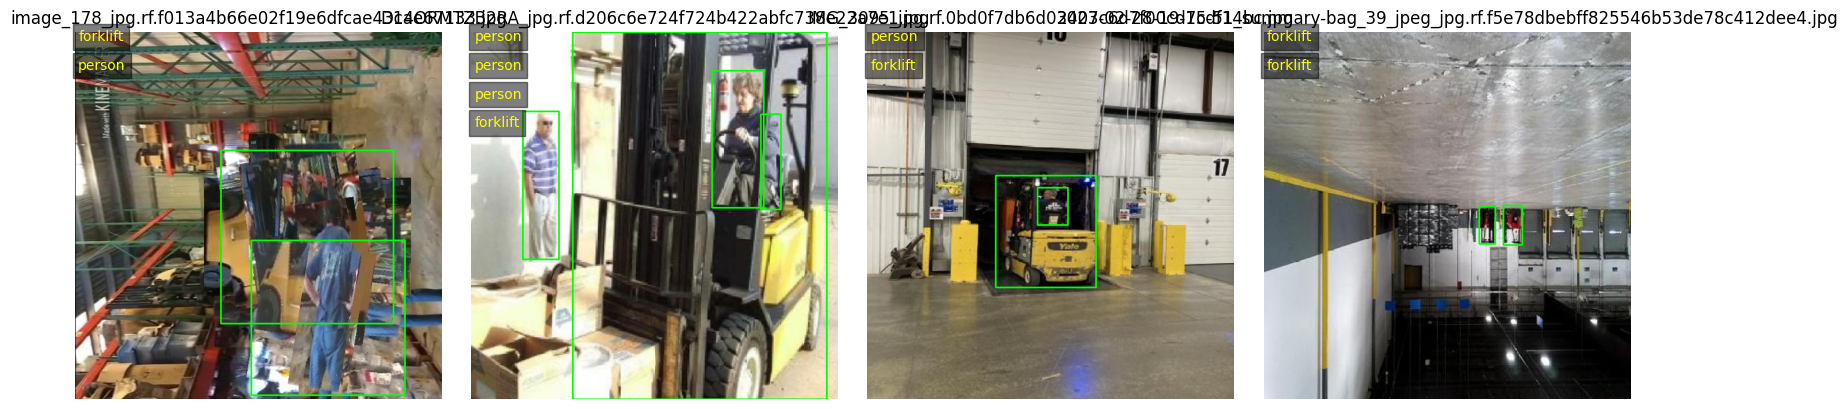

In [ ]:
def draw_yolo_bbox(img, bbox, color=(0,255,0), thickness=2):
    H, W = img.shape[:2]
    cx, cy, bw, bh = bbox
    x1 = int((cx - bw/2) * W)
    y1 = int((cy - bh/2) * H)
    x2 = int((cx + bw/2) * W)
    y2 = int((cy + bh/2) * H)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    return img

def visualize_samples(img_dir: str, class_names: list, n=4, seed=42):
    rng = random.Random(seed)
    pairs = yolo_label_paths(img_dir)
    sample = rng.sample(pairs, min(n, len(pairs)))
    fig, axes = plt.subplots(1, len(sample), figsize=(4*len(sample), 4))
    if len(sample) == 1:
        axes = [axes]

    for ax, (img_path, lbl_path) in zip(axes, sample):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        labels = read_yolo_labels(lbl_path)
        text_y = 15 # fix position of label
        for (cls_id, cx, cy, w, h) in labels:
            img = draw_yolo_bbox(img, (cx, cy, w, h))
            name = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
            ax.text(5, text_y, name, color='yellow', bbox=dict(facecolor='black', alpha=0.5))
            text_y += 50 # if there are more than 1 label, move down

        ax.imshow(img)
        ax.set_title(Path(img_path).name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dir, class_names, n=4, seed=7)

### What methods would you use to verify the reliability of the labels?

1. First of all: Manual inspection, I could randomly check  10 or 12 images with their respective labels. I believe this would be my first sanity check.

2.  Data Validations.
    - 2.1 Statistical validations:
        * Anomalies as 100% of the image (or 0%)
        * Aspect-ratio histograms.
        * Distribution in objects, areas (check skewness)
    - 2.2. Automated Consistency Checks:
        * Impossible areas (0 widht, 0 height),
        * Negative dimensions
        * Boxes outside image boundaries
        * Duplicate annotations.
        * Bad yolo label formats.

3. Train a small YOLO model.
    * Analyze predictions where the model has high accuracy but disagrees with labels (or low confidence on supposedly clear examples).

4. Co-ocurrence. Certain pairs are expected (e.g person + forklift). But maybe unexpected combinations may indicate mislabeling.

5. Outlier Detection via Feature Embeddings. Extract a crop for each bounding box and compute an embedding using a pre-trained model (e.g. ResNet50 or the YOLO backbone) producing a matrix of shape (N, D). I then project these embeddings to (N, 2) with t-SNE or UMAP. Points that fall far from the cluster of their labeled class are likely annotation errors.


# 2. Training

In [ ]:
# ==============================
# 🔧 HYPERPARAMETERS — EXPERIMENTAL SETUP
# ==============================

# TODO: Fill in the hyperparameters based on your dataset analysis.
# Justify your choices in the Markdown cell above.

EPOCHS = ___
IMGSZ  = ___
BATCH  = ___
DEVICE = "cpu"        # or "cuda" if available

# Try YOLO11; if not available use YOLOv8
weights_try = ["yolo11n.pt", "yolov8n.pt"]
model = None
for w in weights_try:
    try:
        model = YOLO(w)
        print("Using:", w)
        break
    except Exception as e:
        print(f"Failed to load {w}: {e}")

assert model is not None, "Could not load a base model (yolo11n.pt / yolov8n.pt). Install ultralytics and make sure you have an active internet connection to download the weights."


# ==============================
# 🚀 TRAINING — BASELINE EXPERIMENT
# ==============================
# The results object contains metrics, charts, and run directory info.
# Feel free to adjust and rerun with different hyperparameters.

results = model.train(data=DATA_YAML_PATH, epochs=EPOCHS, imgsz=IMGSZ, batch=BATCH, device=DEVICE)
results

### ✏️ Discussion

Explain:
1. Why did you choose these hyperparameters?  
2. How do they affect training time, GPU/CPU usage, and accuracy?  
3. What would you try differently if you had more time or resources?

# 3. Evaluation


> 👉 **Task:** Evaluate your trained model using the validation set defined in `data.yaml`.

Run the following cell to compute key performance metrics
Then, summarize your results and provide your interpretation.

**Guidelines for your analysis:**
- **Quantitative metrics** 
- **Error analysis**
- **Next steps**

In [ ]:
# Put Here your model metrics
# TODO:
# - Run model validation on the dataset below.
# - Capture metrics and save a summary to artifacts/metrics_summary.json.
# - Optionally, add visual analysis (PR curves, confusion matrix).

# Put your model evaluation code here 👇

metrics = model.val(data=DATA_YAML_PATH, imgsz=IMGSZ, device=DEVICE)
try:
    summary = {
        "metrics/mAP50-95(B)": float(metrics.box.map if hasattr(metrics, "box") else getattr(metrics, "map", float("nan"))),
        "metrics/mAP50(B)"   : float(getattr(metrics, "map50", float("nan"))),
        "nc": int(nc),
        "classes": class_names,
        "epochs": EPOCHS,
        "imgsz": IMGSZ,
    }
except Exception as e:
    summary = {"error": str(e)}
    
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/metrics_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

summary


### ✏️ Metrics Interpretation and Analysis

Provide a short written analysis here:

1. **Quantitative Summary:**
   - What are your `mAP50` and `mAP50-95` values?
   - Which classes achieved the highest and lowest detection performance?

2. **Qualitative Analysis:**
   - Describe common failure cases (e.g., small objects missed, overlapping detections, background confusion).
   - Were there any label quality issues or inconsistencies you observed?

3. **Improvement Proposals:**
   - Suggest at least two improvements (data augmentation, loss tuning, class balancing, etc.).
   - How would you validate whether these changes actually help?


# 4. Inference

In [ ]:
VAL_SHOW_N = 4
val_imgs = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    val_imgs.extend(glob.glob(os.path.join(val_dir, ext)))
val_imgs = val_imgs[:VAL_SHOW_N]

pred = model.predict(source=val_imgs, imgsz=IMGSZ, conf=0.25)
# Mostrar con matplotlib (usamos 'plot' de ultralytics para guardar)
out_dir = "runs/predict_display"
os.makedirs(out_dir, exist_ok=True)

fig, axes = plt.subplots(1, len(val_imgs), figsize=(4*len(val_imgs), 4))
if len(val_imgs) == 1:
    axes = [axes]
for ax, r in zip(axes, pred):
    im = r.plot()  # numpy array con anotaciones
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.tight_layout()
plt.show()

# 5. Export and deploy

In [ ]:

export_dir = Path("artifacts")
export_dir.mkdir(parents=True, exist_ok=True)

best_ckpt = None
for p in Path("runs/detect").rglob("weights/best.pt"):
    best_ckpt = p
    break

if best_ckpt and best_ckpt.exists():
    target = export_dir / "model_best.pt"
    target.write_bytes(best_ckpt.read_bytes())
    print("Wheight export to:", target)
else:
    print("'best.pt' not found")

with open(export_dir / "classes.json", "w") as f:
    json.dump({"nc": int(nc), "names": class_names}, f, indent=2)

try:
    _ = model.export(format="onnx", imgsz=IMGSZ)
    onnx_file = None
    for p in Path(".").rglob("*.onnx"):
        onnx_file = p
        break
    if onnx_file:
        (export_dir / "model.onnx").write_bytes(onnx_file.read_bytes())
        print("ONNX export to:", export_dir / "model.onnx")
except Exception as e:
    print("Export ONNX not available:", e)


# 6. TODOs (for the candidate)
- [ ] Analyze the class imbalance and propose strategies (weighting, augmented sampling, focal loss).
- [ ] Tune hyperparameters (epochs, image size, augmentations) to improve mAP.
- [ ] Record key metrics and justify the final baseline.
- [ ] Prepare all necessary artifacts in artifacts/ for the inference service (API).

# 7. Appendix — Notes on relative paths
- This notebook reads data.yaml and infers the paths to images/ and labels/ for train/, val/, and test/.
- If you move data.yaml to another folder, adjust DATA_YAML_PATH.
- If the dataset was downloaded from Roboflow, keep the standard YOLO folder structure.